In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train = pd.read_feather(os.path.join(basepath, 'data/processed/application_train.feather'))
# app_test  = pd.read_feather(os.path.join(basepath, 'data/processed/application_test.feather'))

# bureau       = pd.read_feather(os.path.join(basepath, 'data/processed/bureau.feather'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/processed/prev_app.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/processed/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/processed/pos_cash.pkl'))
# credit_bal  = pd.read_pickle(os.path.join(basepath, 'data/processed/credit_card_balance.pkl'))

CPU times: user 139 ms, sys: 163 ms, total: 302 ms
Wall time: 305 ms


In [4]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,0,1730.430054,17145.0,17145.0,0.0,17145.0,0,15,...,0,12.0,0,0,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,1,25188.615234,607500.0,679671.0,NaN,607500.0,1,11,...,1,36.0,1,1,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,1,15060.735352,112500.0,136444.5,NaN,112500.0,2,11,...,1,12.0,2,2,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,1,47041.335938,450000.0,470790.0,NaN,450000.0,3,7,...,1,12.0,0,3,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,1,31924.394531,337500.0,404055.0,NaN,337500.0,1,9,...,1,24.0,2,4,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [38]:
%%time

res = prev_app.loc[:, ['SK_ID_PREV', 
                       'SK_ID_CURR', 
                       'AMT_CREDIT']]\
        .merge(installments.loc[:, ['SK_ID_PREV', 
                                    'SK_ID_CURR', 
                                    'NUM_INSTALMENT_NUMBER', 
                                    'AMT_INSTALMENT']],
               on=['SK_ID_PREV', 'SK_ID_CURR'],
               how='left'
              )
    
res = res.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

CPU times: user 11 s, sys: 2.16 s, total: 13.2 s
Wall time: 13.2 s


In [28]:
cc = res.groupby('SK_ID_CURR')['NAME_CONTRACT_TYPE'].nunique()
cc = app_train.SK_ID_CURR.map(cc)

ss  = pd.crosstab(cc, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
SK_ID_CURR,,,
1.0,100262,8375,0.077092
2.0,102624,8665,0.077860
3.0,64216,6775,0.095435
4.0,110,30,0.214286


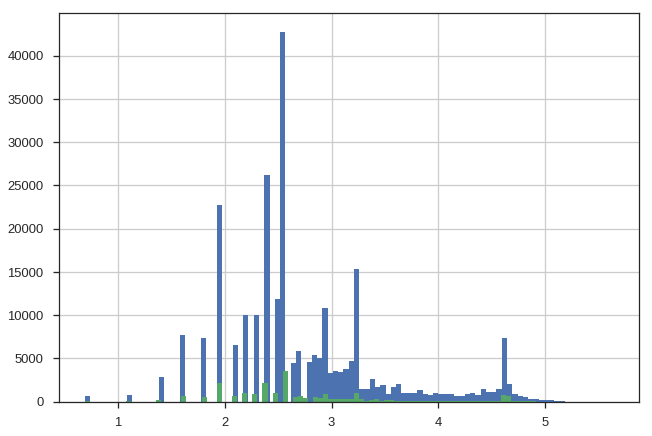

In [37]:
# maximum number of installments paid by user in any of the previous loans
cc = res.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['NUM_INSTALMENT_NUMBER'].max()\
        .groupby('SK_ID_CURR')['NUM_INSTALMENT_NUMBER'].max()
    
cc = app_train.SK_ID_CURR.map(cc)

cc[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
cc[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [5]:
prev_app.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION', 
                 'DAYS_FIRST_DUE', 
                 'DAYS_LAST_DUE',
                 'DAYS_TERMINATION'
                ]]\
        .sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION'], ascending=[True, True, False]).iloc[:50]

,SK_ID_CURR,SK_ID_PREV,DAYS_DECISION,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_TERMINATION
201668,100001,1369693,-1740,-1709.0,-1619.0,-1612.0
892077,100002,1038818,-606,-565.0,-25.0,-17.0
575941,100003,1810518,-746,-716.0,-536.0,-527.0
1223745,100003,2396755,-2341,-2310.0,-1980.0,-1976.0
1021650,100003,2636178,-828,-797.0,-647.0,-639.0
935548,100004,1564014,-815,-784.0,-724.0,-714.0
1259112,100005,1857999,-315,NaN,NaN,NaN
1378978,100005,2495675,-757,-706.0,-466.0,-460.0
1131133,100006,1020698,-438,NaN,NaN,NaN
1232752,100006,1243599,-181,NaN,NaN,NaN


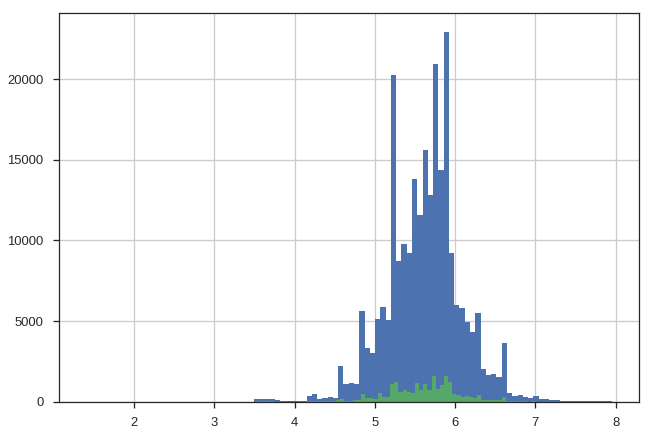

In [11]:
# credit period
periods = prev_app.DAYS_TERMINATION.replace({365243.0: np.nan}) - prev_app.DAYS_DECISION.replace({365243.0: np.nan})
periods = periods.groupby(prev_app.SK_ID_CURR).mean()

periods = app_train.SK_ID_CURR.map(periods)

periods[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
periods[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [58]:
a = a.groupby(prev_app.SK_ID_CURR).mean()
b = b.groupby(prev_app.SK_ID_CURR).mean()

In [60]:
a = app_train.SK_ID_CURR.map(a)
b = app_train.SK_ID_CURR.map(b)

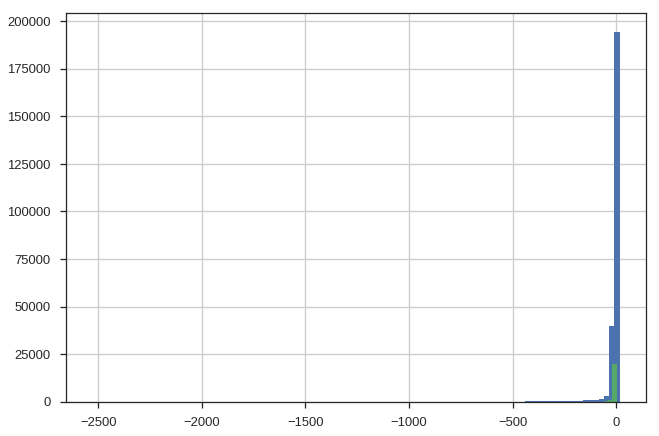

In [71]:
b[(app_train.TARGET == 0)].hist(bins=100)
b[(app_train.TARGET == 1)].hist(bins=100);

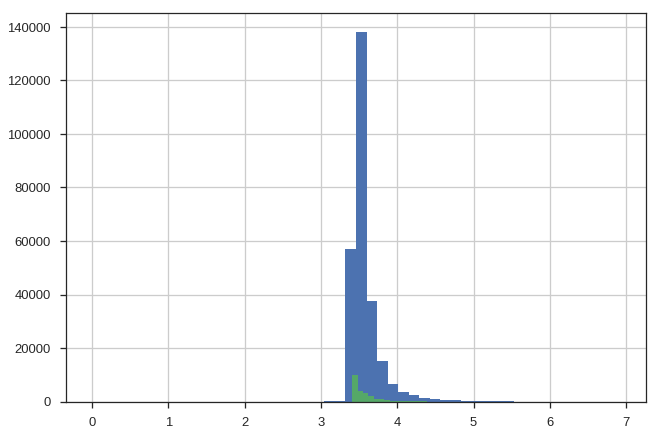

In [65]:

(-a)[app_train.TARGET == 0].map(np.log1p).hist(bins=50)
(-a)[app_train.TARGET == 1].map(np.log1p).hist(bins=50)

In [67]:
(-a)[app_train.TARGET == 0].map(np.log1p).mean(), (-a)[app_train.TARGET == 1].map(np.log1p).mean()

(3.57275268902215, 3.593420288561439)

In [17]:
# difference between approval of last application and days since last time id was changed
most_recent_application = prev_app.replace({'DAYS_DECISION': {365243.0: np.nan}}).groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)\
                          ['DAYS_DECISION'].max().groupby('SK_ID_CURR')['DAYS_DECISION'].max()

most_recent_application = app_train.SK_ID_CURR.map(most_recent_application)
res = app_train.DAYS_ID_PUBLISH - most_recent_application

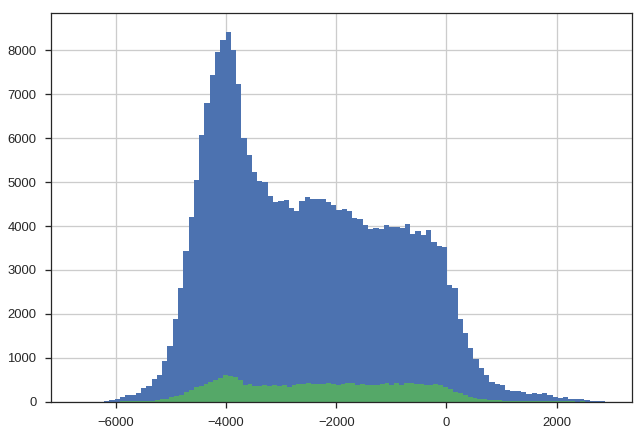

In [19]:
res[(app_train.TARGET == 0)].hist(bins=100)
res[(app_train.TARGET == 1)].hist(bins=100);

In [27]:
# number of different reasons for getting rejection
diff_rejections = prev_app.groupby('SK_ID_CURR')['CODE_REJECT_REASON'].nunique()
diff_rejections = app_train.SK_ID_CURR.map(diff_rejections)

In [29]:
ss = pd.crosstab(diff_rejections, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
SK_ID_CURR,,,
1.0,168290,12794,0.070652
2.0,72363,7293,0.091556
3.0,20999,2804,0.117800
4.0,4694,768,0.140608
5.0,773,169,0.179406
6.0,88,16,0.153846
7.0,5,1,0.166667


In [20]:
# difference between actual and paid amount for installments of previous credits
diff_amt = installments.AMT_INSTALMENT - installments.AMT_PAYMENT
diff_amt = diff_amt.groupby(installments.SK_ID_PREV).mean()
diff_amt = installments.loc[:, ['SK_ID_CURR', 'SK_ID_PREV']]\
                       .merge(diff_amt.reset_index().rename(columns={0: 'mean_diff_amt'}), 
                              on='SK_ID_PREV', 
                              how='left').drop('SK_ID_PREV', axis=1)
    
diff_amt = diff_amt.groupby('SK_ID_CURR')['mean_diff_amt'].max()
diff_amt = app_train.SK_ID_CURR.map(diff_amt)

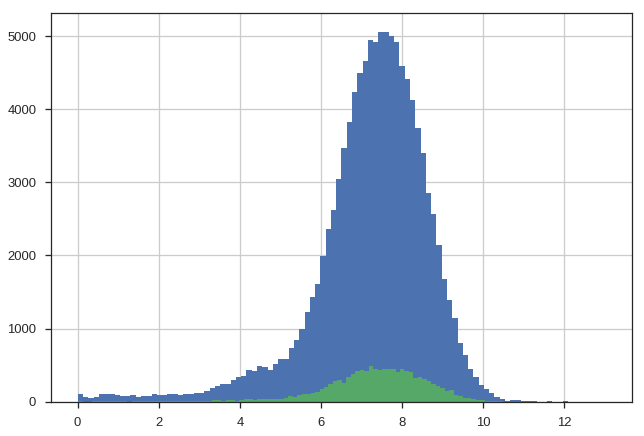

In [27]:
diff_amt[(diff_amt > 0) & (app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
diff_amt[(diff_amt > 0) & (app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

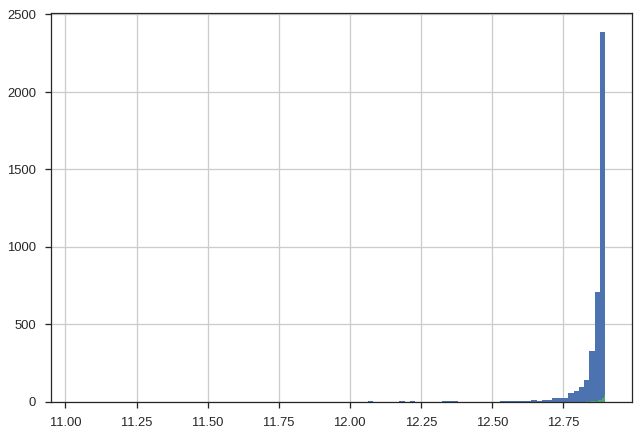

In [30]:
diff_amt[(diff_amt < 0) & (app_train.TARGET == 0)].map(lambda x: np.log1p(x + 400000)).hist(bins=100)
diff_amt[(diff_amt < 0) & (app_train.TARGET == 1)].map(lambda x: np.log1p(x + 400000)).hist(bins=100);

In [38]:
# difference between actual and paid amount for installments of previous credits
diff_amt = installments.AMT_INSTALMENT - installments.AMT_PAYMENT
diff_amt = diff_amt.groupby(installments.SK_ID_CURR).mean()

diff_amt = app_train.SK_ID_CURR.map(diff_amt)

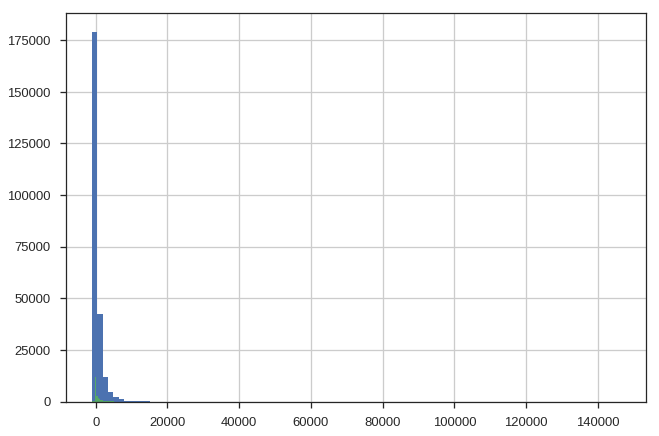

In [45]:
diff_amt[(diff_amt > -1000) & (app_train.TARGET == 0)].hist(bins=100)
diff_amt[(diff_amt > -1000) & (app_train.TARGET == 1)].hist(bins=100);

In [6]:
pos_cash.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, True, False])

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,1,0,0
4704415,1369693,100001,-54,4.0,1.0,0,0,0
7823681,1369693,100001,-55,4.0,2.0,0,0,0
8789081,1369693,100001,-56,4.0,3.0,0,0,0
7167007,1369693,100001,-57,4.0,4.0,0,0,0
4928574,1851984,100001,-93,4.0,0.0,1,0,0
8531326,1851984,100001,-94,4.0,0.0,0,0,0
1891462,1851984,100001,-95,4.0,1.0,0,7,7
1261679,1851984,100001,-96,4.0,2.0,0,0,0
6626366,1038818,100002,-1,24.0,6.0,0,0,0


In [17]:
mean_remaining_installments = pos_cash.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['CNT_INSTALMENT_FUTURE'].min()\
        .drop('SK_ID_PREV', axis=1)\
        .groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].sum()
        
mean_remaining_installments = app_train.SK_ID_CURR.map(mean_remaining_installments)

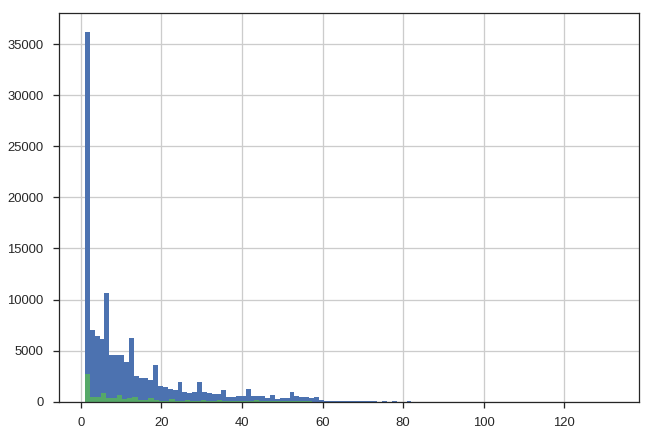

In [19]:
mean_remaining_installments[(mean_remaining_installments > 0) & (app_train.TARGET == 0)].hist(bins=100)
mean_remaining_installments[(mean_remaining_installments > 0) & (app_train.TARGET == 1)].hist(bins=100);

In [39]:
# running loans
running_loans = prev_app.DAYS_TERMINATION.map(lambda x: (x > 0) or pd.isnull(x)).astype(np.uint8)
running_loans = running_loans.groupby(prev_app.SK_ID_CURR).sum()
running_loans = app_train.SK_ID_CURR.map(running_loans)

In [40]:
ss = pd.crosstab(running_loans, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
SK_ID_CURR,,,
0.0,67584,5133,0.070589
1.0,61831,5033,0.075272
2.0,42140,3612,0.078947
3.0,28748,2560,0.081768
4.0,19663,1962,0.090728
5.0,13558,1369,0.091713
6.0,9386,1059,0.101388
7.0,6512,747,0.102907
8.0,4666,564,0.107839


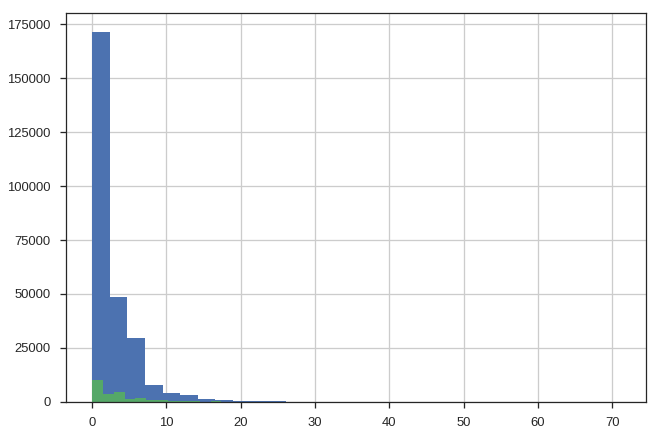

In [42]:
running_loans[(app_train.TARGET == 0)].hist(bins=30)
running_loans[(app_train.TARGET == 1)].hist(bins=40);

In [13]:
# number of loans taken by a person reported to Home Credit
res = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']]\
      .sort_values(by=['SK_ID_CURR', 'SK_ID_BUREAU'])
    
res = res.DAYS_CREDIT.map(lambda x: x > -(365 * 2)).astype(np.uint8)
res = res.groupby(bureau.SK_ID_CURR).sum()
res = app_train.SK_ID_CURR.map(res)

In [16]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
SK_ID_CURR,,,
0.0,50977,3001,0.055597
1.0,65907,4920,0.069465
2.0,48848,3946,0.074743
3.0,31747,2882,0.083225
4.0,19277,1931,0.091051
5.0,11235,1241,0.099471
6.0,6360,832,0.115684
7.0,3498,560,0.137999
8.0,2077,361,0.148072


In [23]:
# total interest rates
res = prev_app.loc[(prev_app.DAYS_TERMINATION > 0) | (prev_app.DAYS_TERMINATION.isnull()), ['SK_ID_CURR', 'SK_ID_PREV', 
                 'RATE_DOWN_PAYMENT',
                 'RATE_INTEREST_PRIVILEGED',
                 'RATE_INTEREST_PRIMARY', 'DAYS_TERMINATION']]
res = res.RATE_INTEREST_PRIVILEGED.fillna(0)

In [24]:
res = res.groupby(prev_app.SK_ID_CURR).sum()
res = app_train.SK_ID_CURR.map(res)

In [25]:
res[res > 0].shape, res.shape

((1620,), (307511,))

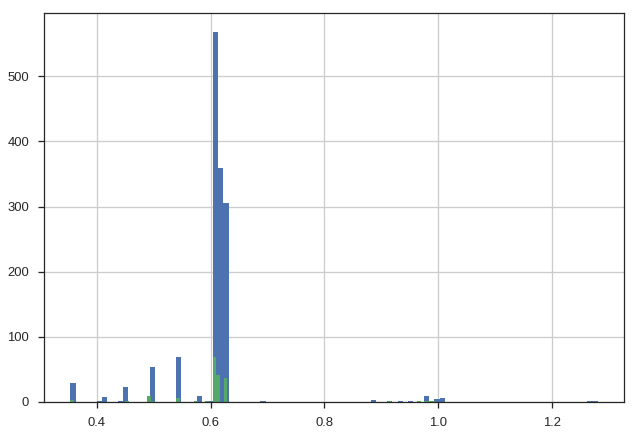

In [26]:
res[(res > 0) & (app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(res > 0) & (app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [23]:
# annuity of the running loans
res = prev_app.loc[(prev_app.DAYS_TERMINATION > 0) | (prev_app.DAYS_TERMINATION.isnull()), :]
res = res.groupby('SK_ID_CURR')[['AMT_CREDIT', 'AMT_ANNUITY']].sum()
res = (res.AMT_ANNUITY / res.AMT_CREDIT).replace([np.inf, -np.inf], np.nan)
res = app_train.SK_ID_CURR.map(res)

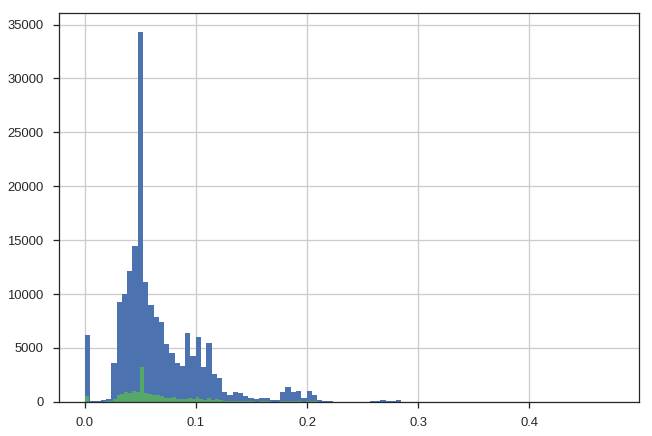

In [27]:
res[(app_train.TARGET == 0)].hist(bins=100)
res[(app_train.TARGET == 1)].hist(bins=100);

In [9]:
app_train.AMT_INCOME_TOTAL.head()

0    202500.0
1    270000.0
2     67500.0
3    135000.0
4    121500.0
Name: AMT_INCOME_TOTAL, dtype: float32